# COVID-19 Cough classification notebook

## Importing Libraries

In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,scale
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#Keras
import keras
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Extracting the Spectrogram for every Audio File

In [2]:
#Loading CSV file
train_csv = pd.read_csv("../input/coughclassifier-trial/cough_trial_extended.csv") #Đọc file csv
dataset = "../input/coughclassifier-trial/cough_trial_extended.csv" # Đường dẫn
anothercsv = pd.read_csv('../input/coughclassifier-trial/cough_dataset.csv')
print (train_csv.head(4)) # Lấy 4 giá trị đầu tiên
print (anothercsv)

                     file_properties      class
0    0v8MGxNetjg_ 10.000_ 20.000.wav  not_covid
1    1j1duoxdxBg_ 70.000_ 80.000.wav  not_covid
2  1MSYO4wgiag_ 120.000_ 130.000.wav  not_covid
3     1PajbAKd8Kg_ 0.000_ 10.000.wav  not_covid
                                               file     status
0    cough-shallow-3CwioNQVDBQ6CttLyFVRJpMpVHk2.wav      covid
1                       pos-0421-084-cough-m-50.wav      covid
2      cough-heavy-6T43bddKoKfG7MwnJWvrPZSsyrc2.wav      covid
3      cough-heavy-hNAGUEhL2Nh7V89at3yFEjQYo6c2.wav      covid
4      cough-heavy-hte8VptUoGVFEqvHpbh5brgfcNP2.wav      covid
..                                              ...        ...
745               6lbkx_tf50g_ 220.000_ 230.000.wav  not_covid
746                 KoUw2T0QKgY_ 70.000_ 80.000.wav  not_covid
747                  X0kpF1at8lM_ 0.000_ 10.000.wav  not_covid
748                 j7MwYU5VH1s_ 70.000_ 80.000.wav  not_covid
749                 o-TJISpYLFc_ 50.000_ 60.000.wav  not_covid

[75

In [3]:
print (train_csv['class'].unique()) #Tìm số class trong cột class
print(anothercsv['status'].unique())
print ('\n', train_csv['class'])

['not_covid' 'covid']
['covid' 'not_covid']

 0      not_covid
1      not_covid
2      not_covid
3      not_covid
4          covid
         ...    
165    not_covid
166    not_covid
167    not_covid
168    not_covid
169    not_covid
Name: class, Length: 170, dtype: object


tot_rows 170 số cột:  2
0v8MGxNetjg_ 10.000_ 20.000


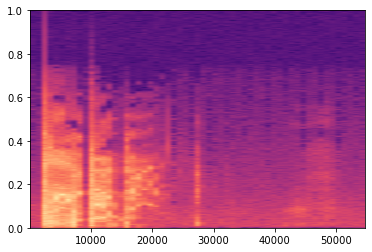

In [4]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
print ('tot_rows',tot_rows, 'số cột: ', train_csv.shape[1])
for i in range(1): #Thay range(1) = range(tot_rows)
    source = train_csv['file_properties'][i]
    filename = '../input/coughclassifier-trial/trial_covid/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='magma', sides='default', mode='default', scale='dB');
    #plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    print (source[:-4]) #Bỏ đi 4 kí tự cuối là ".wav"
    #plt.clf() 

All the audio files get converted into their respective spectrograms .We can know easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [5]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}' #Có f thì hàm trong ' ' mới chạy
header += ' label'
header = header.split()
print (header)

['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


## Writing data to csv file

We write the data to a csv file

source 1MSYO4wgiag_ 120.000_ 130.000.wav

label not_covid
source 1PajbAKd8Kg_ 0.000_ 10.000.wav

label not_covid
data_new_extended
                             filename  chroma_stft      rmse  \
0  1MSYO4wgiag_ 120.000_ 130.000.wav     0.496666  0.033657   
1     1PajbAKd8Kg_ 0.000_ 10.000.wav     0.407549  0.013452   

   spectral_centroid  spectral_bandwidth      rolloff  zero_crossing_rate  \
0        3426.768344         2785.170961  6885.740153            0.225315   
1        2683.604188         2648.709381  5741.888428            0.142076   

        mfcc1      mfcc2      mfcc3  ...    mfcc12    mfcc13    mfcc14  \
0 -282.297913  48.581680 -15.522367  ... -6.066336 -4.167640  1.017302   
1 -346.857300  75.765617  -7.648193  ...  5.053118 -0.291308  0.987186   

     mfcc15    mfcc16    mfcc17    mfcc18    mfcc19    mfcc20      label  
0 -0.523806  0.538693 -8.855953 -2.927977 -1.118562 -5.906227  not_covid  
1 -2.447526  3.692367  2.312328 -2.059656 -4.772599 -0.503851  not_covid 

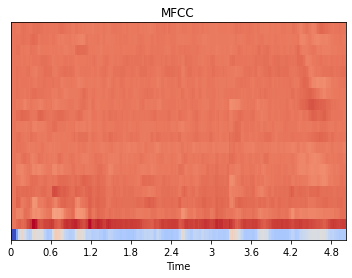

In [6]:
file = open('data_new_extended.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
data_new_extended = pd.read_csv('../input/coughclassifier-trial/data_new_extended.csv')
#print ('data_new_extended\n',data_new_extended)
for i in range(2,4):
        source = train_csv['file_properties'][i]
        print ('source',source)
        file_name = '../input/coughclassifier-trial/trial_covid/'+source
        label =  train_csv['class'][i]
        print ('\nlabel', label)
        y,sr = librosa.load(file_name, mono=True, duration=5)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=1024)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,hop_length=1024)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,hop_length=1024) #Nên có hop-length
        #print ('spec_cent',spec_cent, 'shape:',spec_cent.shape)
        #print ('spec_bw',spec_bw, 'shape:',spec_bw.shape)
        #print ('rolloff',rolloff, 'shape:',rolloff.shape)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        #print ('mfcc',mfcc)
        to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        #np.mean tính trung bình giá trị
        librosa.display.specshow(mfcc, x_axis='time') #Show MFCC
        plt.title('MFCC')
        #plt.show()
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {label}'
        value = [str(source)]
        value.extend(to_append.split())
        file = open('data_new_extended.csv', 'a')
        with file:
            writer = csv.writer(file)
            writer.writerow(value)
            
data_new_extended = pd.read_csv('./data_new_extended.csv')
print ('data_new_extended\n',data_new_extended)

S.shape (129, 318)


[Text(0.5, 1.0, 'Mel-frequency spectrogram 2')]

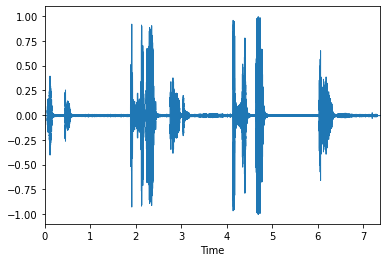

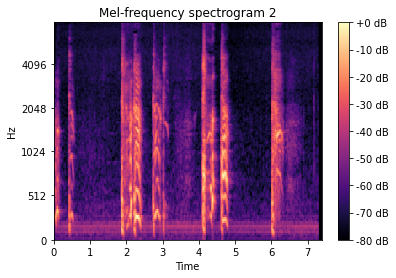

In [7]:
# Drawing mel spectrogram
y,sr = librosa.load('../input/coughclassifier-trial/trial_covid/-ej81N6Aqo4_ 0.000_ 8.000.wav', mono=True)
fig, ax = plt.subplots(sharex=True, sharey=True)
#draw sound with time axis 
librosa.display.waveplot(y, sr=sr, max_points=50000.0, x_axis='time')

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=129,fmax=8000)

print ('S.shape',S.shape)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram 2')

**I will add more data into this** with positive: 669 (16.45% of total) negative cases: 3399. 

This data concludes 3 raw primary features (no normalization).
1. Mell
2. Chroma
3. MFCC


In [8]:
mel_mean_feature = pd.read_csv('../input/covid-19-cough-primary-features/mel_mean_feature.csv')
mfcc_mean_feature = pd.read_csv('../input/covid-19-cough-primary-features/mfcc_mean_feature.csv')
chroma_mean_feature = pd.read_csv('../input/covid-19-cough-primary-features/chroma_mean_feature.csv')
data2 = pd.concat([mfcc_mean_feature.iloc[:, :-1],mel_mean_feature.iloc[:, :-1],chroma_mean_feature], axis = 1)
print (data2.shape)
print(data2.head(4))

(4068, 154)
            0          1          2          3          4          5  \
0 -469.700104  49.046539 -13.098398   5.316383  12.601670 -12.358564   
1 -264.004364  20.026585 -13.823114   1.303919  -3.382437  -5.861396   
2 -528.200684  33.507336  -6.445586  -5.512868   4.005277  -1.471756   
3 -411.655151  64.029152 -38.050503  14.265171 -29.784332  10.094859   

          6         7          8          9  ...         3         4  \
0 -7.281440  6.289607  -2.296032  -7.903307  ...  0.634772  0.586549   
1 -2.548569 -1.592095  -4.633652  -2.843869  ...  0.844946  0.885113   
2 -4.403562 -2.394212  -2.342109  -1.108230  ...  0.447705  0.449705   
3 -1.046007 -2.994242 -14.407915 -19.332296  ...  0.577924  0.591584   

          5         6         7         8         9        10        11  label  
0  0.467221  0.453897  0.478933  0.506346  0.550227  0.554043  0.547200      0  
1  0.857370  0.762331  0.713360  0.707977  0.759170  0.804480  0.814533      0  
2  0.466175  0.483180  



# Analysing the Data set

I'll try on new 4068-case datase. 

Label 0: negative, label 1: positive

In [9]:
# This code is for 170-case dataset

#data = pd.read_csv('../input/coughclassifier-trial/data_new_extended.csv')
#print (data.iloc[:,-1] )
#for i in range(0,len(data.iloc[:,-1])):
#    if data.iloc[i ,-1] == 'not_covid':
#        data.iloc[i ,-1] = '0'
#    else:
#        data.iloc[i ,-1] = '1'
#data.head(6)    

In [10]:
# This code is for 4068-case dataset 
data = data2
print ('data.shape',data.shape)
data.head(3)

data.shape (4068, 154)


,0,1,2,3,4,5,6,7,8,9,...,3,4,5,6,7,8,9,10,11,label
0,-469.700104,49.046539,-13.098398,5.316383,12.601670,-12.358564,-7.281440,6.289607,-2.296032,-7.903307,...,0.634772,0.586549,0.467221,0.453897,0.478933,0.506346,0.550227,0.554043,0.547200,0
1,-264.004364,20.026585,-13.823114,1.303919,-3.382437,-5.861396,-2.548569,-1.592095,-4.633652,-2.843869,...,0.844946,0.885113,0.857370,0.762331,0.713360,0.707977,0.759170,0.804480,0.814533,0
2,-528.200684,33.507336,-6.445586,-5.512868,4.005277,-1.471756,-4.403562,-2.394212,-2.342109,-1.108230,...,0.447705,0.449705,0.466175,0.483180,0.471616,0.445039,0.418582,0.401697,0.407227,0


In [11]:
# This code is for 170 - case dataset

# Dropping unneccesary columns
#data = data.drop(['filename'],axis=1)
#print (data.shape)

## Encoding the Labels

In [12]:
genre_list = data.iloc[:, -1]
#print ('genre_list\n',genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list) #Gán nhãn 0,1 cho class. Có thể nói là đưa về one hot coding
neg, pos = np.bincount(y)
total = neg + pos
print ('positive: {} ({:.2f}% of total) \nnegative cases: {}'.format(pos, 100 * pos/total ,neg)) 

positive: 669 (16.45% of total) 
negative cases: 3399


## Scaling the Feature columns

> Just to give you an example — if you have multiple independent variables like age, salary, and height; With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range, for example- centered around 0 or in the range (0,1) depending on the scaling technique.

Reference: https://www.atoti.io/when-to-perform-a-feature-scaling/

In [13]:
scaler = StandardScaler()
print ('X before scaling:\n',np.array(data.iloc[:, :-1]))
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #không scale 2 cột file name, label
print ('\nX after scaling:\n',X,'\nX.shape', X.shape)

X before scaling:
 [[-4.69700104e+02  4.90465393e+01 -1.30983982e+01 ...  5.50227463e-01
   5.54043233e-01  5.47199726e-01]
 [-2.64004364e+02  2.00265846e+01 -1.38231144e+01 ...  7.59170115e-01
   8.04479778e-01  8.14533114e-01]
 [-5.28200684e+02  3.35073357e+01 -6.44558573e+00 ...  4.18581694e-01
   4.01697159e-01  4.07226652e-01]
 ...
 [-3.45741821e+02  1.83624100e+02  2.94156151e+01 ...  6.22704327e-01
   5.40030837e-01  5.27234375e-01]
 [-3.60228210e+02  1.90446991e+02  4.37801056e+01 ...  5.77975929e-01
   5.29206097e-01  5.30464530e-01]
 [-3.50179291e+02  1.84252747e+02  4.28334999e+01 ...  6.49643898e-01
   5.85025251e-01  5.66047251e-01]]

X after scaling:
 [[-0.46537288 -0.28645247  0.10902158 ... -0.62466659 -0.4848842
  -0.45210151]
 [ 1.47121681 -1.20954032  0.06761458 ...  0.81243547  1.20082384
   1.30503144]
 [-1.01614569 -0.78073477  0.48913313 ... -1.53012273 -1.51033759
  -1.37211865]
 ...
 [ 0.70167284  3.99428853  2.53807962 ... -0.12617263 -0.57920274
  -0.58333006

## Dividing data into training and Testing set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, 
                                                    random_state = None, stratify = y)
#print (y_test)
print (len(y_test))

814


In [15]:
print('X_train.shape:',X_train.shape)
print('\nX_train.shape[1]:',X_train.shape[1])
print ('\ny_train.shape:',y_train.shape)

X_train.shape: (3254, 153)

X_train.shape[1]: 153

y_train.shape: (3254,)


# Classification with Keras

## Building our Network

I add some drop out layers to avoid overfitting

In [16]:
def get_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],))) #Đầu vào đã được transpose

    model.add(layers.Dense(256, activation='relu'))

    model.add(Dropout(0.2))

    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(64, activation='relu'))

    model.add(Dropout(0.2))

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model
#Model này có dấu hiệu over fitting nên cho drop out

# plot model
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               78848     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                6

In [17]:
# # loading weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [18]:
batch_size = 16
early_stopping_patience = 10

# Add early stopping

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./model_{epoch:02d}.h5', 
                                       save_freq='epoch', 
                                       save_best_only=True,
                                       period = 10),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]



history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks = my_callbacks,
                    validation_split=0.15)

Epoch 1/100
173/173 [==============================] - 1s 3ms/step - loss: 0.4132 - accuracy: 0.8373 - val_loss: 0.3382 - val_accuracy: 0.8671
Epoch 2/100
173/173 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8665 - val_loss: 0.3320 - val_accuracy: 0.8589
Epoch 3/100
173/173 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.8875 - val_loss: 0.2936 - val_accuracy: 0.8753
Epoch 4/100
173/173 [==============================] - 0s 3ms/step - loss: 0.2418 - accuracy: 0.9038 - val_loss: 0.2864 - val_accuracy: 0.8855
Epoch 5/100
173/173 [==============================] - 0s 2ms/step - loss: 0.2213 - accuracy: 0.9114 - val_loss: 0.2586 - val_accuracy: 0.8937
Epoch 6/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9277 - val_loss: 0.2461 - val_accuracy: 0.9080
Epoch 7/100
173/173 [==============================] - 1s 4ms/step - loss: 0.1572 - accuracy: 0.9400 - val_loss: 0.2909 - val_accuracy: 0.9100

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


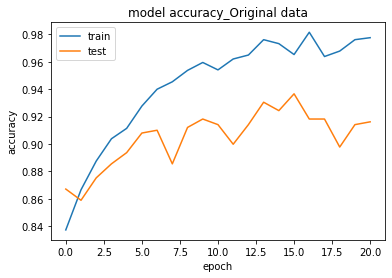

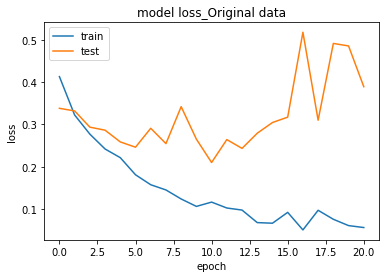

In [19]:
def history_loss_acc(history,name):
    # list all data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy_'+name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss_'+name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

history_loss_acc(history, 'Original data')

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Predictions on Test Data

In [21]:
test_loss, test_acc = model.evaluate(X_test,y_test) 

26/26 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.8993


In [22]:
print('test_acc: ',test_acc)

test_acc:  0.8992629051208496


In [23]:
predictions = model.predict(X_test)
#print ('so predict:',len(predictions))
#print('\npredictions[0].shape',predictions[0].shape)
#print('\nnp.sum(predictions)',np.sum(predictions[0]))
#print('\npredictions[:4]\n',predictions[:4])
#print('\ny_test',y_test[:4])
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)
#predict = np.argmax(predictions[4])
#print ('predict\n',y_predict)

In [24]:
# This code is for 170- case dataset

#!tar -zcvf outputname.tar.zip /kaggle/working

In [25]:
#print ('y_test',y_test)
#print('y_predict',y_predict)

# Evaluation 

## Confusion_matrix
Recall, precision, F1-score, fpr, tpr

Reference: https://machinelearningcoban.com/2017/08/31/evaluation/#-receiver-operating-characteristic-curve

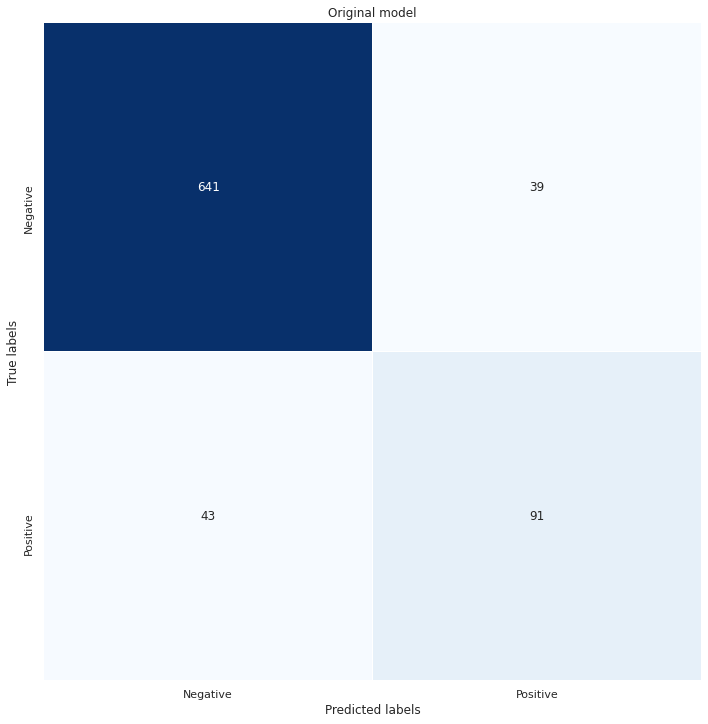

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       680
    Positive       0.70      0.68      0.69       134

    accuracy                           0.90       814
   macro avg       0.82      0.81      0.81       814
weighted avg       0.90      0.90      0.90       814



In [26]:
## predictions = np.array([1 if x >= 0.5 else 0 for x in seed_final_test])
def evaluate_matrix(y_test, y_predict, name):
    cm = confusion_matrix(y_test, y_predict)
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

    plt.figure(figsize=(10, 10))

    sns.set(font_scale=1)

    ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    plt.title(name)

    plt.show()

    print(classification_report(y_test, y_predict, target_names=["Negative", "Positive"]))
    
evaluate_matrix(y_test, y_predict, 'Original model')

## ROC_curve

model: Original data 
AUC = 0.9110074626865672


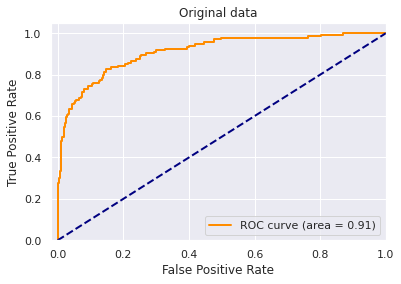

In [27]:
# summarize score
#print(predictions[:,1], '\n',predictions[:,1].shape )
def ROC_curve(y_test,predictions,name):
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions[:,1])
    print ('model: {} \nAUC = {}'. format(name, auc(lr_fpr, lr_tpr)))
    # plot the roc curve for the model
    lw = 2
    plt.plot(lr_fpr, lr_tpr, color="darkorange",
             lw=lw, label="ROC curve (area = %0.2f)" % auc(lr_fpr, lr_tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    plt.title(name)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

ROC_curve(y_test,predictions,'Original data')

# Imbalanced data

As you can see, our project is imbalanced positive: 669 (16.45% of total), negative cases: 3399
There are a alot of proposed methods to solve this like: over sampling, undersampling, gain more data,...

Reference: https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html#45-thu-th%E1%BA%ADp-th%C3%AAm-quan-s%C3%A1t

In this project. I'll try resolving the imbalanced data by oversampling with SMOTE

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [28]:
print ('original positive cases: {}  and  total cases: {}'.format(pos, total) )
# transform the dataset
oversample = SMOTE(sampling_strategy=0.5, k_neighbors=5) #pos is equal to 50% neg
X_os, y_os = oversample.fit_resample(X_train, y_train)

order = np.arange(len(y_os))
np.random.shuffle(order)
X_os = X_os[order]
y_os = y_os[order]

neg_os, pos_os = np.bincount(y_os)
total_os = neg_os + pos_os
print ('\nAfter oversampling \nnegative cases: {}  \npositive cases: {} ({:.2f}% of total)'.format(neg_os, pos_os, 100 * pos_os/total_os )) 

original positive cases: 669  and  total cases: 4068

After oversampling 
negative cases: 2719  
positive cases: 1359 (33.33% of total)


In [29]:
history_os = model.fit(X_os, y_os,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks = my_callbacks,
                    validation_split=0.15)

Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 0.1426 - accuracy: 0.9504 - val_loss: 0.1125 - val_accuracy: 0.9673
Epoch 2/100
217/217 [==============================] - 0s 2ms/step - loss: 0.1282 - accuracy: 0.9582 - val_loss: 0.1356 - val_accuracy: 0.9493
Epoch 3/100
217/217 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9587 - val_loss: 0.1486 - val_accuracy: 0.9542
Epoch 4/100
217/217 [==============================] - 1s 3ms/step - loss: 0.0951 - accuracy: 0.9686 - val_loss: 0.1400 - val_accuracy: 0.9690
Epoch 5/100
217/217 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.9703 - val_loss: 0.1130 - val_accuracy: 0.9608
Epoch 6/100
217/217 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9801 - val_loss: 0.1300 - val_accuracy: 0.9624
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.0789 - accuracy: 0.9769 - val_loss: 0.1309 - val_accuracy: 0.9559

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


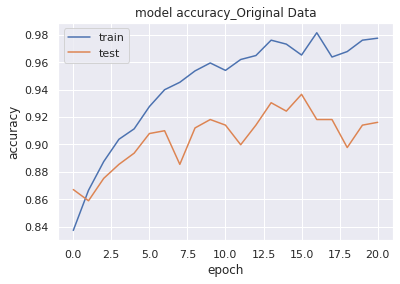

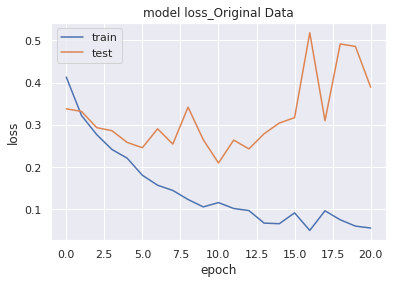

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


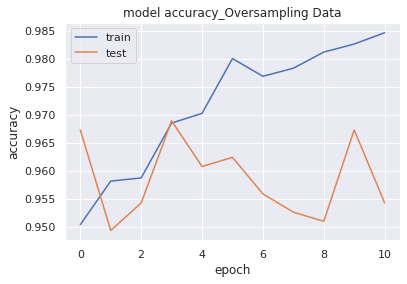

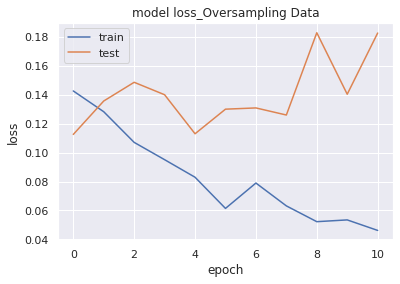

In [30]:
history_loss_acc(history,'Original Data')
history_loss_acc(history_os,'Oversampling Data')

In [31]:
test_loss_os, test_acc_os = model.evaluate(X_test,y_test) 
print ('test_acc_os',test_acc_os)
predictions_os = model.predict(X_test)
y_predict_os =[]
for i in range(len(predictions_os)):
    predict = np.argmax(predictions_os[i])
    y_predict_os.append(predict)
#predict = np.argmax(predictions[4])
#print ('predict_os\n',y_predict_os)

26/26 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9275
test_acc_os 0.9275184273719788


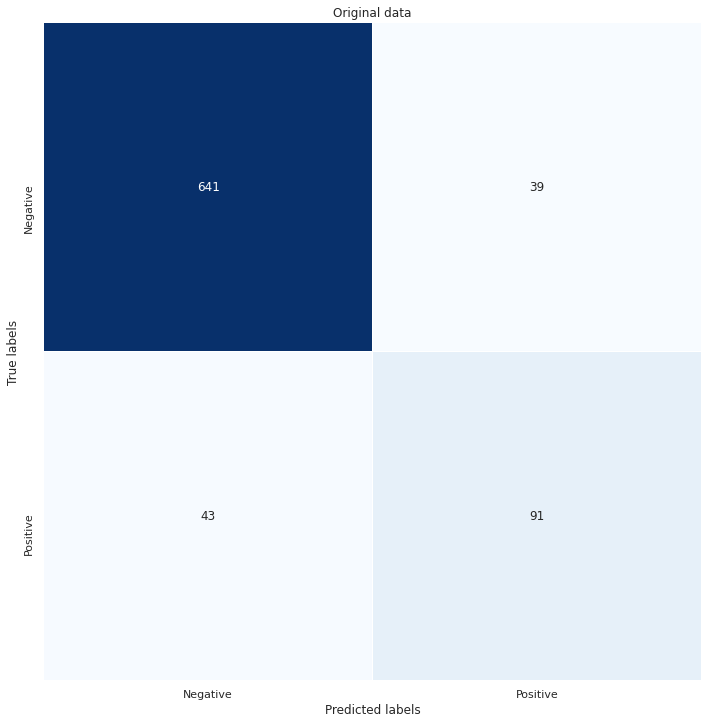

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       680
    Positive       0.70      0.68      0.69       134

    accuracy                           0.90       814
   macro avg       0.82      0.81      0.81       814
weighted avg       0.90      0.90      0.90       814



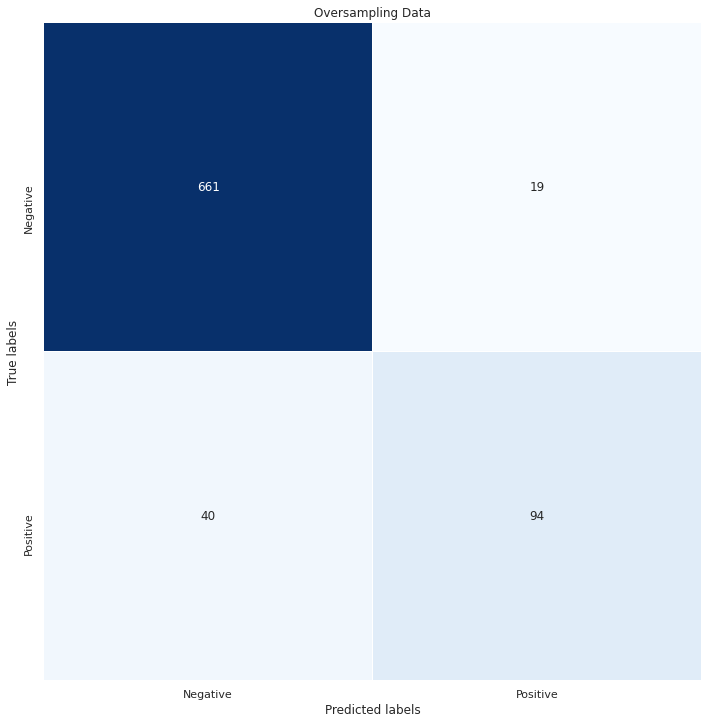

              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96       680
    Positive       0.83      0.70      0.76       134

    accuracy                           0.93       814
   macro avg       0.89      0.84      0.86       814
weighted avg       0.92      0.93      0.92       814



In [32]:
## predictions = np.array([1 if x >= 0.5 else 0 for x in seed_final_test])
evaluate_matrix(y_test, y_predict,'Original data')
evaluate_matrix(y_test, y_predict_os, 'Oversampling Data')

model: Original data 
AUC = 0.9110074626865672


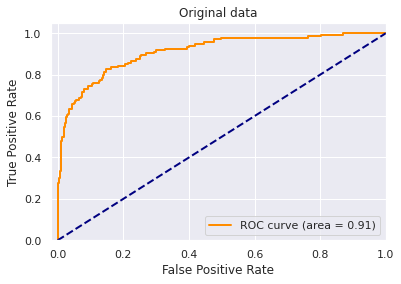

model: Oversampling Data 
AUC = 0.9311128182616331


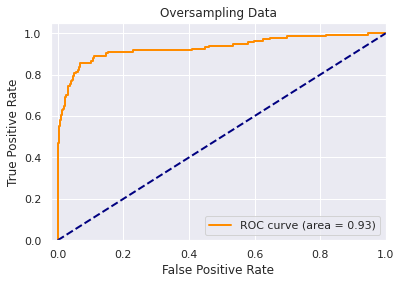

In [33]:
# summarize score
ROC_curve(y_test, predictions,'Original data')
ROC_curve(y_test, predictions_os, 'Oversampling Data')

In [34]:
#print('y_test ',y_test)
#print('y_predict_origin_data ',y_predict)
#print('y_predict_os ',y_predict_os)

**Conclusion about SMOTE based on this project and reference here: https://www.kaggle.com/theoviel/dealing-with-class-imbalance-with-smote**

It appears that SMOTE does not really help improve the results (sometimes it hepls but sometime it doesn't). Yu should run the model several times. However, it makes the network learning faster.

Moreover, there is one big problem, this method is not compatible larger datasets

# Combining K fold cross validation

Here I use K-fold (Stratified k fold) with the oversampled data

After all, I think K-fold is just a method to generally assessed how good or bad the model is. Help us tune the hyperparameters better

Reference:
* https://viblo.asia/p/lam-chu-stacking-ensemble-learning-Az45b0A6ZxY
* https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
* https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras/blob/master/stratified_K_fold_CV.ipynb
* https://miai.vn/2021/01/18/k-fold-cross-validation-tuyet-chieu-train-khi-it-du-lieu/

In [35]:
accuracy_list = []
loss_list = []

# K-Fold CV
kfold = StratifiedKFold(n_splits=5, shuffle=True)
# We should use Stratified KFold for binary cassification & huge class imbalance

# K-fold Cross Validation model evaluation
fold_idx = 1

for train_ids, val_ids in kfold.split(X_os, y_os):
    
    model = get_model()

    print("\nBắt đầu train Fold ", fold_idx)

    # Train model
    model.fit(X_os[train_ids], y_os[train_ids],
              batch_size=16,
              epochs=25,
              callbacks = my_callbacks,
              verbose=1)


    # Test và in kết quả
    scores = model.evaluate(X_os[val_ids], y_os[val_ids], verbose=0)
    print("Đã train xong Fold ", fold_idx)
    print(f'> Fold {fold_idx} - Loss: {scores[0]} - Accuracy: {100* scores[1]}%')
    
    # Thêm thông tin accuracy và loss vào list
    accuracy_list.append(scores[1] * 100)
    loss_list.append(scores[0])

    # To the next fold
    fold_idx = fold_idx + 1


Bắt đầu train Fold  1
Epoch 1/25
204/204 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7646
Epoch 2/25
204/204 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8544
Epoch 3/25
204/204 [==============================] - 0s 2ms/step - loss: 0.2711 - accuracy: 0.8899
Epoch 4/25
204/204 [==============================] - 1s 3ms/step - loss: 0.2202 - accuracy: 0.9093
Epoch 5/25
204/204 [==============================] - 1s 3ms/step - loss: 0.1868 - accuracy: 0.9224
Epoch 6/25
204/204 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9390
Epoch 7/25
204/204 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9525
Epoch 8/25
204/204 [==============================] - 0s 2ms/step - loss: 0.1463 - accuracy: 0.9531
Epoch 9/25
204/204 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9651
Epoch 10/25
204/204 [==============================] - 0s 2ms/step - loss: 0.

In [36]:
# In kết quả tổng thể
print('* Chi tiết các fold')
for i in range(0, len(accuracy_list)):
    print(f'> Fold {i+1} - Loss: {loss_list[i]} - Accuracy: {accuracy_list[i]}%')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accuracy_list)} (Độ lệch +- {np.std(accuracy_list)})')
print(f'> Loss: {np.mean(loss_list)}')


* Chi tiết các fold
> Fold 1 - Loss: 0.1653546392917633 - Accuracy: 94.48529481887817%
> Fold 2 - Loss: 0.24054491519927979 - Accuracy: 96.32353186607361%
> Fold 3 - Loss: 0.22137568891048431 - Accuracy: 95.09803652763367%
> Fold 4 - Loss: 0.20622101426124573 - Accuracy: 94.47852969169617%
> Fold 5 - Loss: 0.2650053799152374 - Accuracy: 94.47852969169617%
* Đánh giá tổng thể các folds:
> Accuracy: 94.97278451919556 (Độ lệch +- 0.7164395770257685)
> Loss: 0.21970032751560212


## Model finalization
> If you’re satisfied with the performance of your model, you can finalize it. There are two options for doing so:
> 
>* Save the best performing model instance (check “How to save and load a model with Keras?” – do note that this requires retraining because you haven’t saved models with the code above), and use it for generating predictions.


>* Retrain the model, but this time with all the data – i.e., without making the train/test split. Save that model, and use it for generating predictions. I do suggest to continue using a validation set, as you want to know when the model is overfitting.

Reference: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#model-finalization

For me, I prefer the latter

In [37]:
# Train model
history_cv = model.fit(X_os, y_os,
          batch_size=16,
          epochs=100,
          callbacks = my_callbacks,
          verbose=1)
model.save('./kfold.h5')

# load model and predict
loaded_model = get_model()
loaded_model.load_weights('./kfold.h5')
predictions_cv = loaded_model.predict(X_test)
y_predict_cv =[]
for i in range(len(predictions_cv)):
    predict = np.argmax(predictions_cv[i])
    y_predict_cv.append(predict)
#predict = np.argmax(predictions[4])
#print ('predict_cv\n',y_predict_cv)

Epoch 1/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0966 - accuracy: 0.9698
Epoch 2/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0641 - accuracy: 0.9792
Epoch 3/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0616 - accuracy: 0.9838
Epoch 4/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0446 - accuracy: 0.9838
Epoch 5/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0401 - accuracy: 0.9850
Epoch 6/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0295 - accuracy: 0.9904
Epoch 7/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9848
Epoch 8/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0274 - accuracy: 0.9897
Epoch 9/100
255/255 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.9858
Epoch 10/100
255/255 [==============================] - 1s 2ms/step - loss: 0.0385 - accura

# Comparison on Original data, Oversampling data and K fold

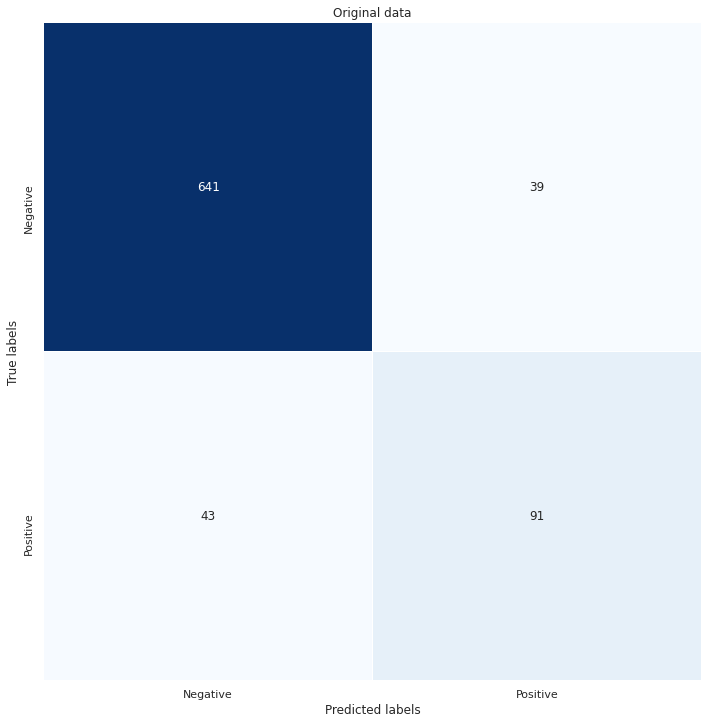

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94       680
    Positive       0.70      0.68      0.69       134

    accuracy                           0.90       814
   macro avg       0.82      0.81      0.81       814
weighted avg       0.90      0.90      0.90       814



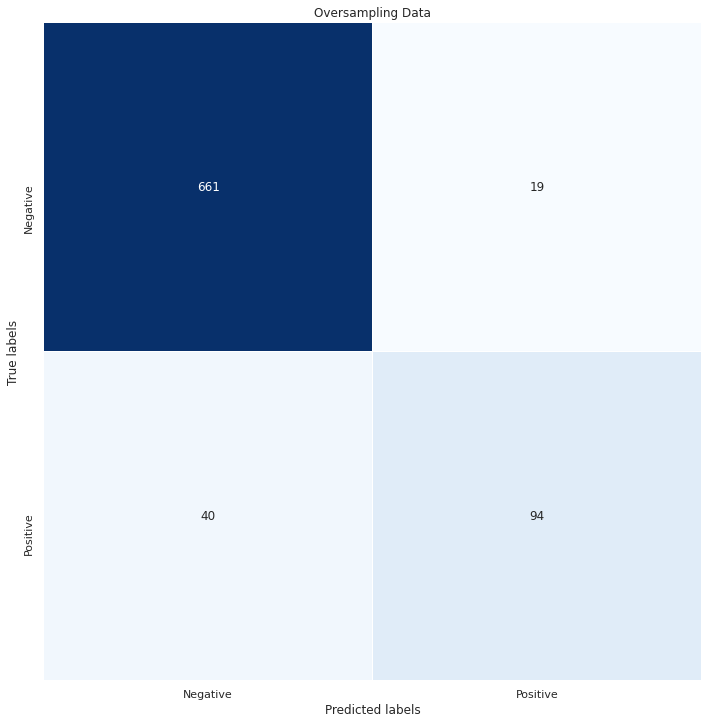

              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96       680
    Positive       0.83      0.70      0.76       134

    accuracy                           0.93       814
   macro avg       0.89      0.84      0.86       814
weighted avg       0.92      0.93      0.92       814



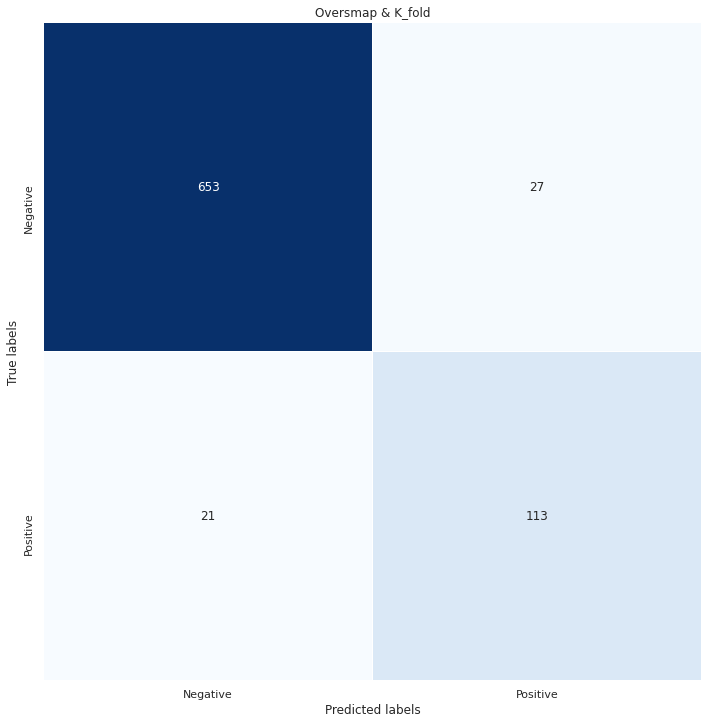

              precision    recall  f1-score   support

    Negative       0.97      0.96      0.96       680
    Positive       0.81      0.84      0.82       134

    accuracy                           0.94       814
   macro avg       0.89      0.90      0.89       814
weighted avg       0.94      0.94      0.94       814

model: Original data 
AUC = 0.9110074626865672


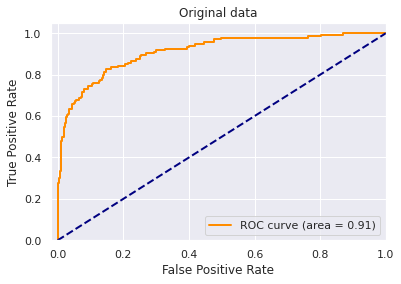

model: Oversampling Data 
AUC = 0.9311128182616331


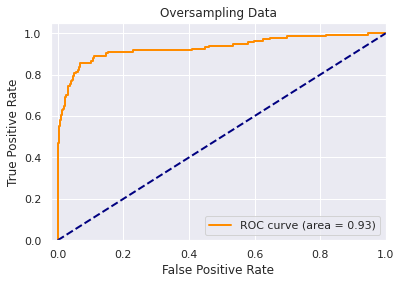

model: Oversamp & K_fold 
AUC = 0.9509438103599649


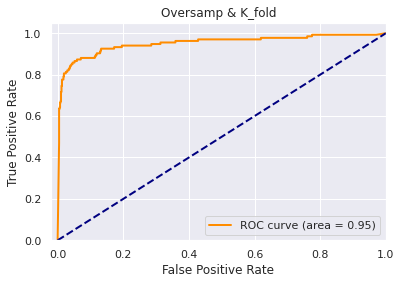

In [38]:
## predictions = np.array([1 if x >= 0.5 else 0 for x in seed_final_test])
evaluate_matrix(y_test, y_predict,'Original data')
evaluate_matrix(y_test, y_predict_os, 'Oversampling Data')
evaluate_matrix(y_test, y_predict_cv, 'Oversmap & K_fold')
# summarize score
ROC_curve(y_test, predictions,'Original data')
ROC_curve(y_test, predictions_os, 'Oversampling Data')
ROC_curve(y_test, predictions_cv, 'Oversamp & K_fold')

#print('y_test ',y_test)
#print('y_predict_origin_data ',y_predict)
#print('y_predict_os ',y_predict_os)
#print('y_predict_cv ',y_predict_cv)